In [101]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from glob import  glob
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A

In [102]:
IMG_DIR =   "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/train_img"
MASK_DIR =  "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/train_masks"

In [75]:
images = sorted(glob(IMG_DIR+"/*.jpg"))
masks = sorted(glob(MASK_DIR+"/*.bmp"))

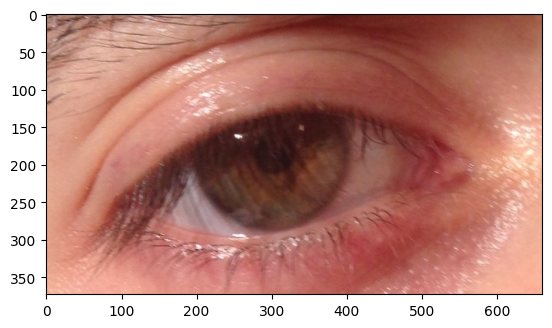

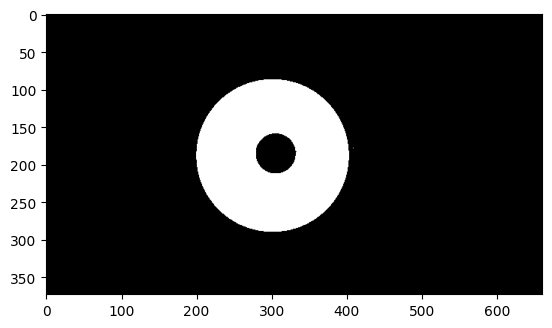

In [166]:
idx = 200
img = cv2.imread(images[idx])
mask = cv2.imread(masks[idx])

plt.imshow(img[:,:,::-1])
plt.show()
plt.imshow(mask)
plt.show()

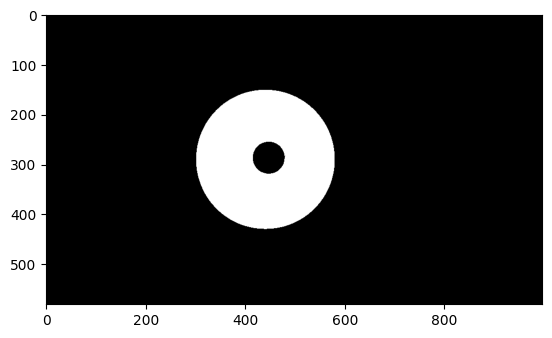

In [167]:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

plt.imshow(opening)

In [168]:
def findRadiusIris(mask):
    
   
    edge_detected_image = cv2.Canny(mask, 0, 200)
    
    
    # plt.imshow(edge_detected_image)
    # plt.show()
    
    contours, hierarchy = cv2.findContours(edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
    
    
    cnt = min(contours, key = cv2.contourArea) # finding contour with #maximum area
    
    # print(cnt)
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    
    
    return cx,cy

305 185


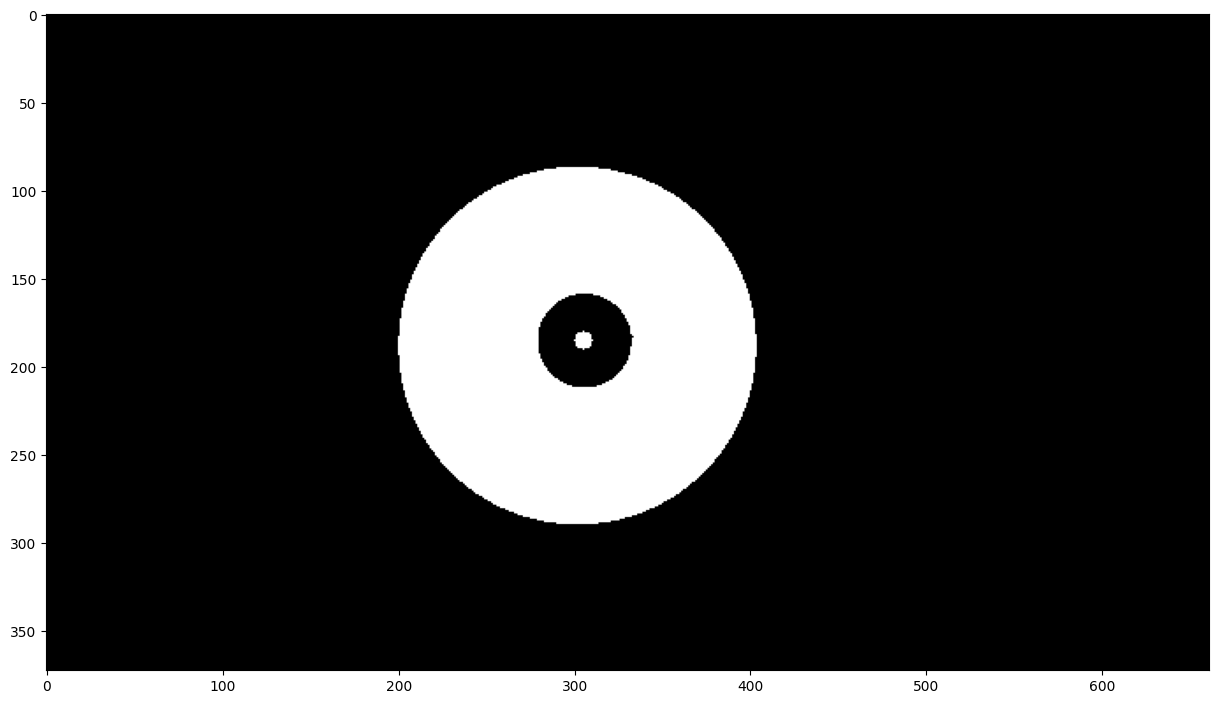

In [169]:
cx,cy = findRadiusIris(mask)
print(cx,cy)

plt.figure(figsize=(15,15))
cv2.circle(mask,(cx,cy),5,(255,255,255),-1)
plt.imshow(mask)

In [170]:
def regressionPrediction(model,image,mean,std):
        
       
        
        
        unnorm = UnNormalize(mean=mean, std=std)
        
    
        
        img = imgTransform(image=image[:,:,::-1],resize_amt=RESIZE_AMT_REGRESSION,mean=mean,std=std)
        
       
        
        img = img.unsqueeze(0).to(device)
        
        with torch.no_grad():
                out_coord = model(img)
        
        
        img = img.squeeze(0)

        img = transforms.ToPILImage()(unnorm(img))
        
        
        pred_coord = out_coord.detach().cpu().numpy()[0]
        
        
        
        
        return rescale_coordinate(pred_coord,image,RESIZE_AMT_REGRESSION)

In [171]:
def imgTransform(image,resize_amt,mean,std):
    """ Transform numpy images to Torch tensors

    Args:
        image (_numpy_): _cropped_eye_region_
        resize_amt (_int_): _Input Resize for the image_

    Returns:
        _torch.float32_: _Transformed image tensor_
    """

    
    
    # segmentation
    # mean =(0.5, 0.5, 0.5) std =(0.5, 0.5, 0.5)
    
    transform = A.Compose([
        A.Resize(resize_amt, resize_amt),
        A.augmentations.transforms.Normalize(
            mean=mean, std=std),
        ToTensorV2()
    ])
    
   
    return transform(image=image)["image"]

    

In [172]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [173]:
def rescale_coordinate(coord,original_image,resize_amt):
    
    h,w = original_image.shape[:2]
    coord[0] = int((coord[0]/resize_amt) * w)
    coord[1] = int((coord[1]/resize_amt) * h)
    
    
    return coord

In [174]:
def load_model(model_path):
    """Load Regression model

    Args:
        model_path (_str_): _model path_
    

    Returns:
        _torch model_: _RESNET model_
    """

    model = torch.load(model_path,map_location=device)

    model.eval()

    return model

In [175]:
import sys
sys.path.append("../")
from BaseModels.resnetModels import BB_model
device = 'cuda' if torch.cuda.is_available() else "cpu"
from torchvision import transforms

regression_model_path = "/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Iris-Center-Localization/Trained_Models/Resnet_32_IMG_SIZE__32/Regression_model_0.25639680131442016.pth"


REGRESSION_MODEL = load_model(
    model_path=regression_model_path)



RESIZE_AMT_REGRESSION = 32

In [176]:
pred = regressionPrediction(REGRESSION_MODEL,img,mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))

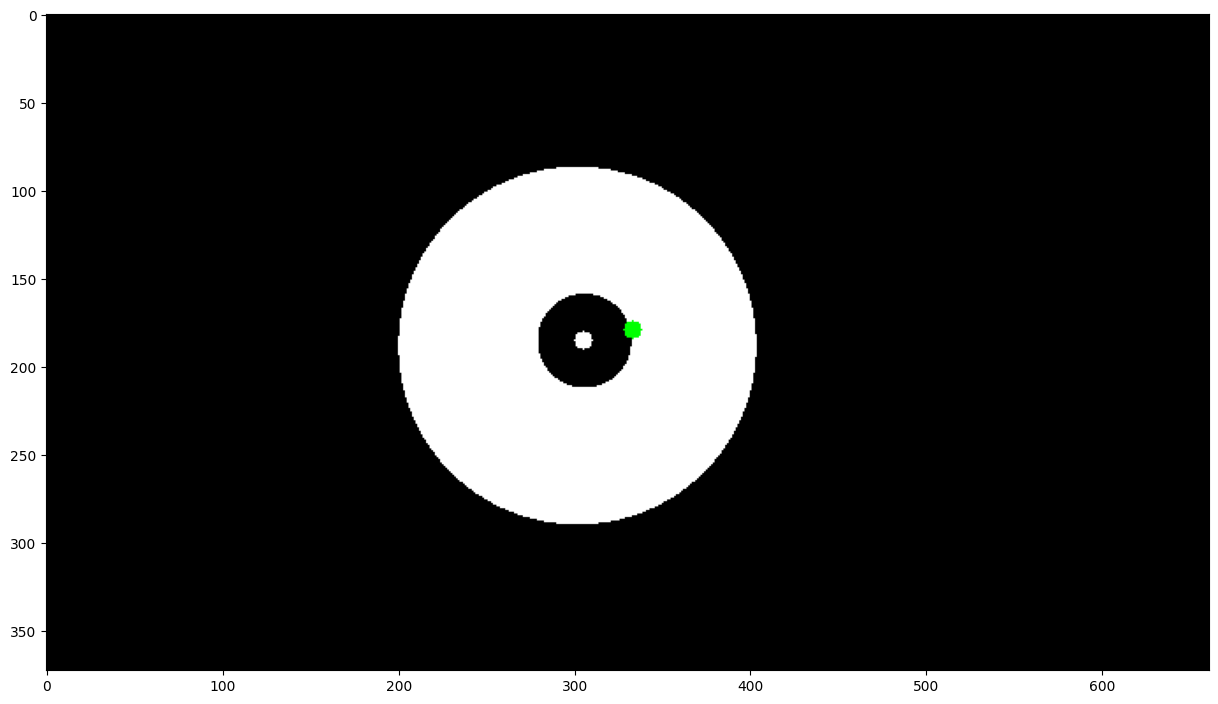

In [177]:
cv2.circle(mask,(int(pred[0]),int(pred[1])),5,(0,255,0),-1)

plt.figure(figsize=(15,15))
plt.imshow(mask)